# **<center>A basics Generative Adversarial Network (GAN) model created to generate new fashion line. The model is trained with the fashion_mnist datasets using Tensorflow Machine Learning Library</center>**

### Here are two models are created,
### - *A Generative model* 
### - *A Discriminative model*

The generative model is setup so as to be rewarded for creating images that are not easily recognizable by the discriminative model as **FAKE** and the discriminative model is setup so as to be rewarded for recognizing **FAKE** images generated, from **REAL** ones. A custom training loop is setup to have the two model go against each other back and forth so as to make the generative model created more accurate and hard to detect images through more training.

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [ ]:
! nvidia-smi

Tue Apr  4 05:25:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importing the tensorflow datasets api

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# loading the fashion_mnist dataset by calling the tensorflow dataset api

ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKUYG37/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKUYG37/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# printing the feature names for the dataset

ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [ ]:
ds.as_numpy_iterator().next()['label']

2

# **2. Visualization of Data & Building the Dataset**

In [ ]:
# data transformation

import numpy as np

# setup connection aka iterator

data_iterator = ds.as_numpy_iterator()

# getting data out of the pipline
data_iterator.next()

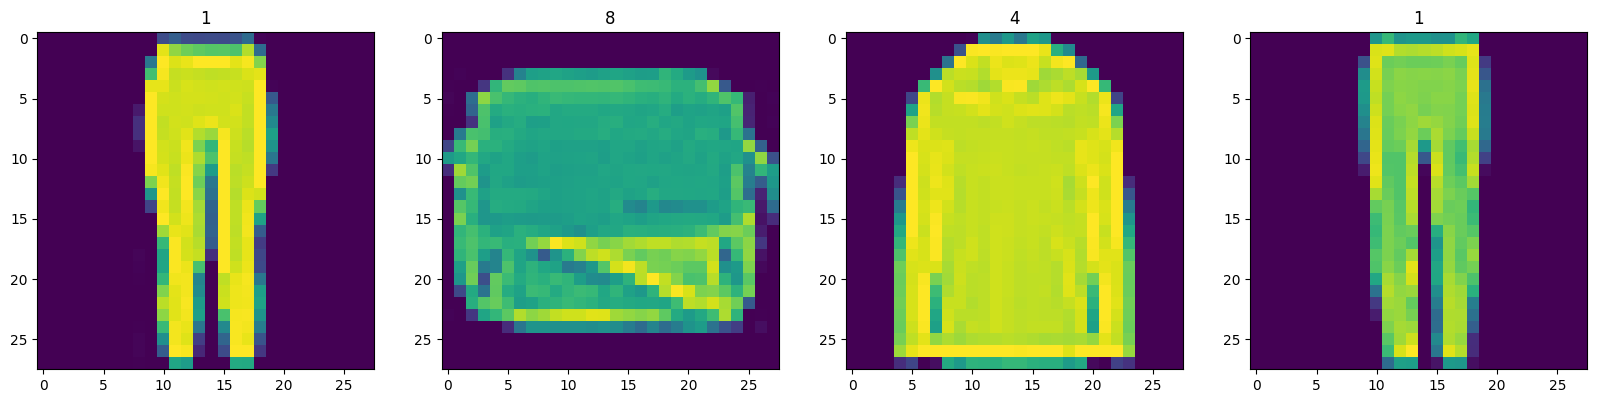

In [ ]:
# plotting the images

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# loop four times and get images
for idx in range(4):
  
  # grabbing an image and label

  batch = data_iterator.next()

  # plot the image using a specific subplot

  ax[idx].imshow(np.squeeze(batch['image']))

  ax[idx].title.set_text(batch['label'])

In [ ]:
# Scale and return images only 
def scale_images(data):
  image = data['image']
  return image / 255
  

In [ ]:
# building a tensorflow datapipeline

# reloading the dataset from scratch
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# step to reduce possible bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# **3. Building the Neural Network**

####**3.1 Import Modelling Components**

In [ ]:
# importing the Sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# importing the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### **3.2 Build the Generator Model**

In [ ]:
def build_generator():
  model = Sequential()
  
  # Takes in random values and reshape it to 7x7x128
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7, 7, 128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layers to end in a single channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 7s 7s/step


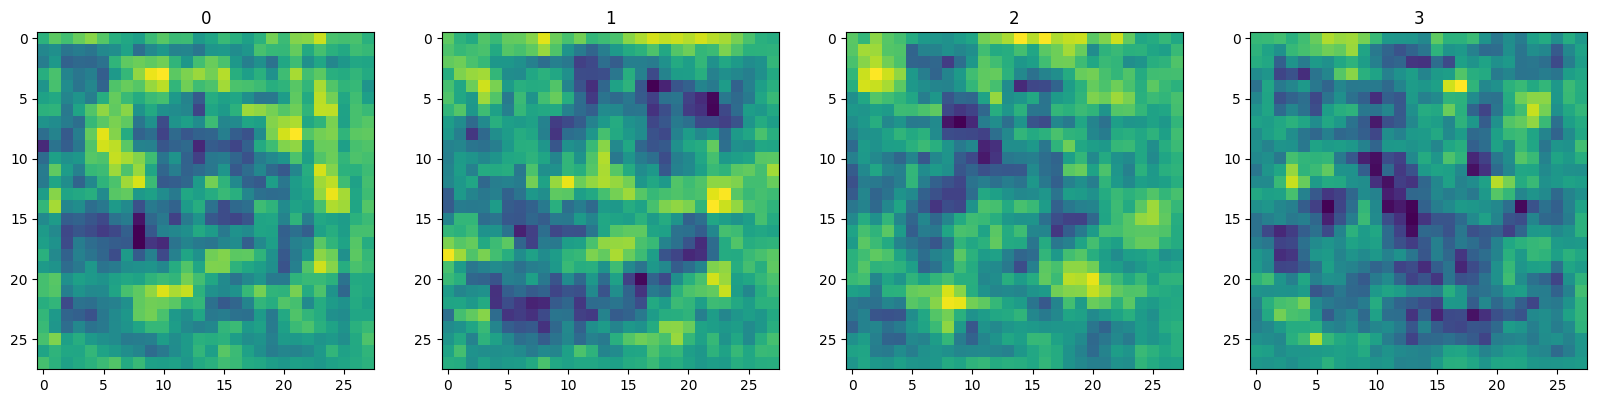

In [ ]:
# Generating images through randomly generated number sample to test the working of the model

img = generator.predict(np.random.randn(4, 128, 1))

# subplot configuration for the images

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# loop through an enumerated images
for idx, image in enumerate(img):

  # plot the image using a specific subplot

  ax[idx].imshow(np.squeeze(image))

  ax[idx].title.set_text(idx)

#### **3.3 Building the Discriminator model**

##### *The Discriminator model is created to classify whether a given image is authentic or generated with GAN we created*

In [ ]:
def build_discriminator():
  model = Sequential()

  # first Covolutional layer
  model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
  model.add(LeakyReLU(0.2)) # LeakyReLU is more prefered as the activation function for GANs in general.
  model.add(Dropout(0.4)) # Regularization

  # second Convolutional layer
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # third Convolutional layer
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # fourth Convolutional layer
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass to Dense layer

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = img[0]

In [ ]:
img.shape

(28, 28, 1)

# **4. Constructing Custom Training Loops**

#### **4.1 Setup Losses and Optimizers**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=(0.00001))
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### **4.2 Build Subclassed model**

In [ ]:
# importing the base model class to subclass out training step
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    
    # create attributes for generator and discriminator

    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)
    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)

      # create label for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # add some noise to the TRUE outputs
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = 0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis = 0)

      # calulate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # apply backpropogation - nn learn
    d_grad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # calculate the loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # apply backpropogation
    g_grad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}


In [ ]:
# create a instance of the subclass

f_gan = FashionGAN(generator, discriminator)

In [ ]:
# compile the model

f_gan.compile(g_opt, d_opt, g_loss, d_loss)

#### **4.3 Build Callback**

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
  def __init__(self, num_img = 3, latent_dim = 128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs = None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
    
  # loop through an enumerated images
  for idx, image in enumerate(img):

    # plot the image using a specific subplot

    ax[idx].imshow(np.squeeze(image))

    ax[idx].title.set_text(idx)


#### **4.4 Train**

In [ ]:
# Recommended 2000 epoch if you have the time

hist = f_gan.fit(ds, epochs = 20, callbacks = [ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:17 - d_loss: 0.6906 - g_loss: 0.7039

469/469 [==============================] - 92s 174ms/step - d_loss: 0.4449 - g_loss: 1.6962
Epoch 2/20
469/469 [==============================] - 81s 173ms/step - d_loss: -3.5068e-04 - g_loss: 15.6435
Epoch 3/20
469/469 [==============================] - 81s 173ms/step - d_loss: 0.6383 - g_loss: 0.8738
Epoch 4/20
469/469 [==============================] - 81s 173ms/step - d_loss: 0.6546 - g_loss: 0.6503
Epoch 5/20
469/469 [==============================] - 81s 172ms/step - d_loss: 0.6127 - g_loss: 0.6475
Epoch 6/20
469/469 [==============================] - 81s 173ms/step - d_loss: 0.7012 - g_loss: 0.5161
Epoch 7/20
469/469 [==============================] - 81s 173ms/step - d_loss: 0.6453 - g_loss: 0.6874
Epoch 8/20
469/469 [==============================] - 81s 172ms/step - d_loss: 0.6690 - g_loss: 0.5681
Epoch 9/20
469/469 [==============================] - 81s 173ms/step - d_loss: 0.6896 - g_loss: 0.6695
Epoch 10/20
469/469 [==============================] - 81s 173ms/step - d_loss

#### **4.5 Review Performance**

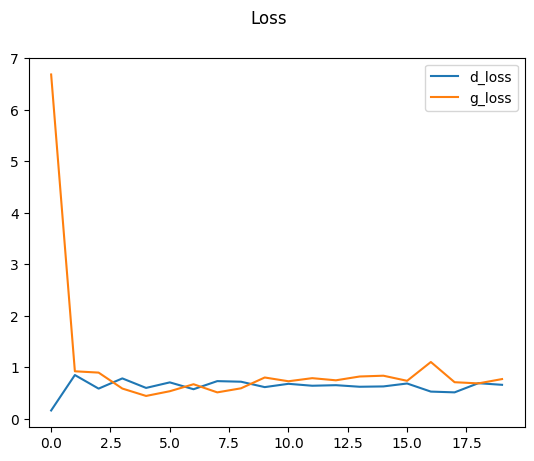

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# **5. Testing the Generator**

#### **5.1 Generate Images**

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

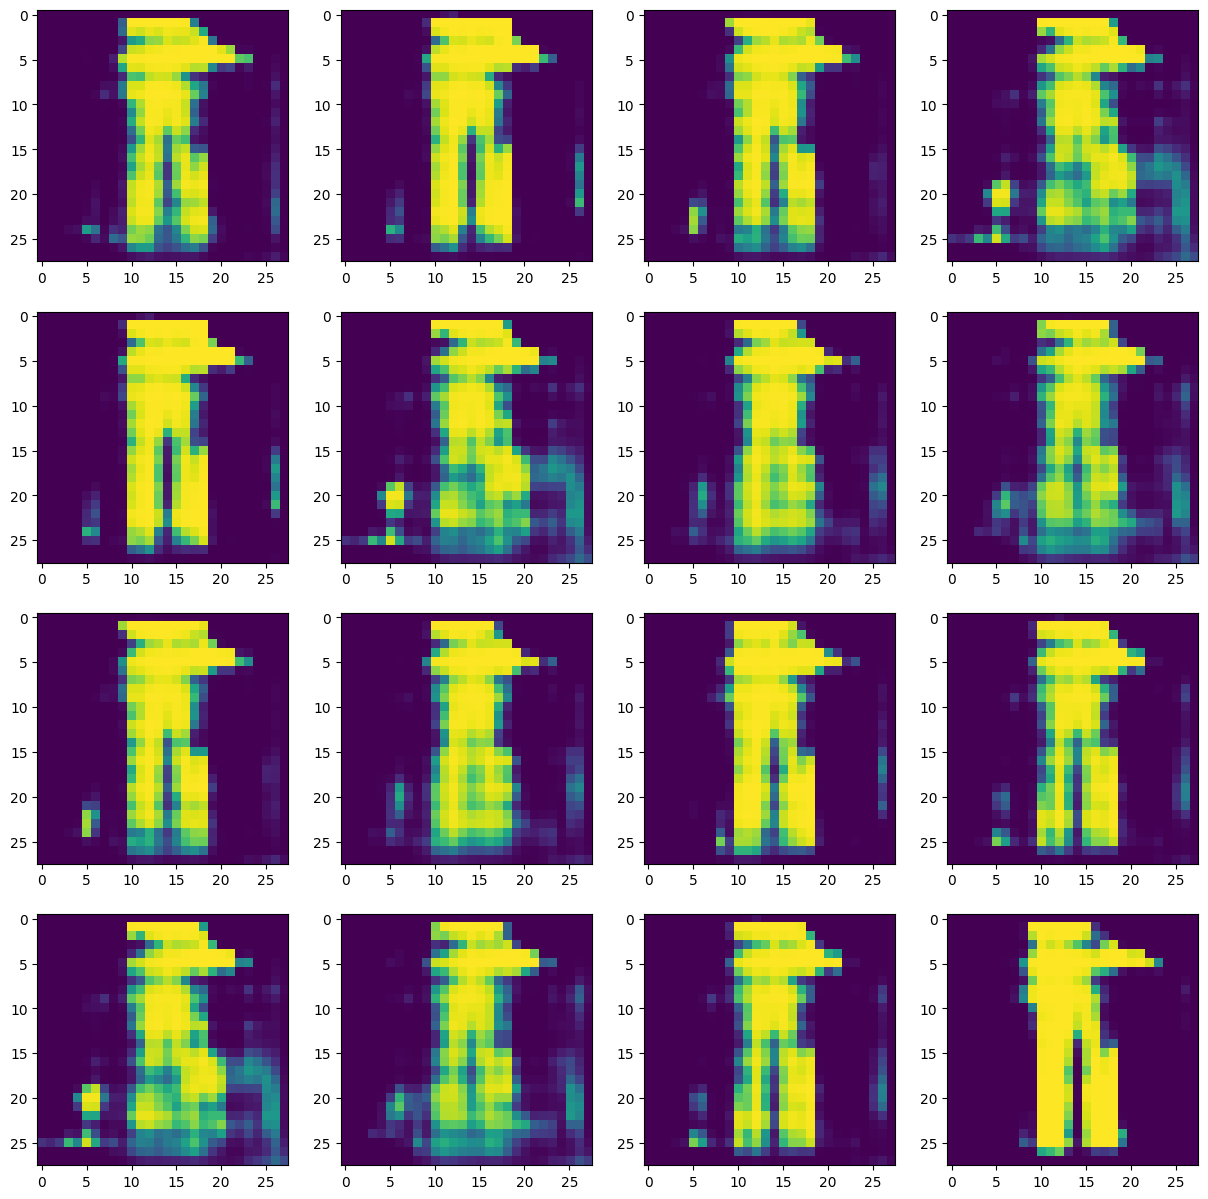

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r + 1) * (c + 1) - 1])

### ***To Produce actual images we shall have to train the model upto atleast 2000 epochs. But due to limited resources we are ending here.***

#### **5.2 Save the model**

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')